In [2]:
import os
# Setting temp dir to /srv/data directory, as it otherwise fills up the home directory too much
# Just comment out on machines that are not "Goober"
os.environ["TMPDIR"] = "/srv/data/tmp"
os.makedirs("/srv/data/tmp", exist_ok=True)

%pip install haystack-ai
%pip install nltk
%pip install markdown-it-py
%pip install mdit_plain
%pip install openai
%pip install pandas
%pip install hf_xet
%pip install ollama-haystack==2.4.2
%pip install rapidfuzz
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from utils.markdown_utils import for_each_markdown_file
from tqdm import tqdm
import pandas as pd
from openai import OpenAI
import json

tqdm.pandas()

In [4]:
from secret import OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Generate Questions with Ground Truth and References

In [4]:
all_data = []
number_of_questions = 10

def generate_questions_for_md_file(filename, bytes):
    print("Generating QA for", filename)
    content = bytes.decode("utf-8")

    prompt = f'''
    Basierend auf dem folgenden Text:
    """
    {content}
    """

    Aufgabe:
    Formuliere {number_of_questions} realistische Patientenfragen, die sich **konkret auf diesen Text beziehen** und sich **ausschließlich mit Informationen aus diesem Text beantworten lassen**.

    Für jede Frage gib bitte ein JSON-Objekt mit folgendem Aufbau zurück:

    - `question`: Eine realistisch formulierte Patientenfrage.
    - `references`: Eine Liste aller relevanten Textstellen (nur einzelne Sätze ohne Überschriften), die zur Beantwortung der Frage notwendig sind.  
      → Die Referenzen müssen **1:1 dem Originaltext entsprechen**, damit sie später exakt gematcht werden können.
    - `groundTruth`: Eine sachliche und vollständige Antwort auf die Frage – **nur basierend auf dem gegebenen Text**.

    Gib das Ergebnis als **valide JSON-Liste mit genau {number_of_questions} Objekten** zurück. Kein Freitext, keine Kommentare, keine Einleitung – nur das JSON-Array.

    Beispielstruktur:
    [
        {{
            "question": string,
            "references": string[],
            "groundTruth": string
        }},
        ...
    ]
    '''

    try:
        response = client.responses.create(
            input=prompt,
            model="gpt-4.1",
            temperature=1.0,
        )

        text = response.output_text.strip()

        if text.startswith("```json"):
            text = text.replace("```json", "").replace("```", "").strip()

        qa = json.loads(text)

        for entry in qa:
            entry["source_file"] = filename

        return qa

    except Exception as e:
        print(f"Error generating QA for file {filename}: {e}")
        return []

all_data = []

def wrapper(filename, bytes):
    all_data.extend(generate_questions_for_md_file(filename, bytes))

for_each_markdown_file("data", wrapper)

df = pd.DataFrame(all_data)

Processing Markdown files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating QA for Äußere Wendung.md


Processing Markdown files:  17%|█▋        | 1/6 [00:38<03:10, 38.16s/it]

Generating QA for Kaiserschnitt.md


Processing Markdown files:  33%|███▎      | 2/6 [01:22<02:48, 42.08s/it]

Generating QA for DRK Geburtshilfe Infos.md


Processing Markdown files:  50%|█████     | 3/6 [01:46<01:40, 33.49s/it]

Generating QA for Medizinische Maßnahmen rund um die Geburt.md


Processing Markdown files:  50%|█████     | 3/6 [02:05<02:05, 41.90s/it]


KeyboardInterrupt: 

In [ ]:
df

,question,references,groundTruth,source_file
0,Wie läuft eine äußere Wendung ab und was passi...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md
1,Wann ist der beste Zeitpunkt für eine äußere W...,[Der optimale Zeitpunkt für eine äußere Wendun...,Der optimale Zeitpunkt ist meist in der 37. od...,Äußere Wendung.md
2,Welche Risiken und Komplikationen kann es bei ...,[Trotz größter Vorsicht kann es bei der äußere...,Zu den möglichen Risiken zählen unter anderem ...,Äußere Wendung.md
3,"Was sind Alternativen zur äußeren Wendung, um ...",[Neben der äußeren Wendung existieren alternat...,Alternativen sind Methoden der Komplementärmed...,Äußere Wendung.md
4,Wann sollte keine äußere Wendung durchgeführt ...,[Bestimmte Bedingungen schließen eine äußere W...,Eine äußere Wendung sollte bei Plazenta praevi...,Äußere Wendung.md
...,...,...,...,...
56,"Was geschieht, wenn nach einem vorzeitigen Bla...",[nach dem Platzen der Fruchtblase ab etwa der ...,Wenn nach dem Platzen der Fruchtblase keine We...,Einleitung der Geburt.md
57,Welche Risiken gibt es speziell bei Frauen mit...,[Frauen mit früheren Operationen an der Gebärm...,Bei Frauen mit früheren Operationen an der Geb...,Einleitung der Geburt.md
58,Wann rät man bei Schwangerschaftsdiabetes zu e...,[Bei Schwangerschaftsdiabetes ist das Kind mit...,"Bei Schwangerschaftsdiabetes, insbesondere unt...",Einleitung der Geburt.md
59,Welche Risiken gibt es bei der Fruchtblasenspr...,"[Wird die Fruchtblase geöffnet, kann bei länge...",Bei der Fruchtblasensprengung kann es bei läng...,Einleitung der Geburt.md


## Generate Question Variations

In [ ]:
for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating question variations"):
    original_question = row["question"]

    prompt = f"""
    Du erhältst eine medizinische Patientenfrage zur Geburtshilfe. Erzeuge daraus drei unterschiedliche Varianten, wie sie in einem Krankenhaus-Chatbot vorkommen könnten:

    1. **Kontextbezogen**: Eine Mini-Konversation mit drei Nachrichten (Patient → Assistent → Rückfrage), bei der die letzte Frage **nur im Kontext der vorherigen verständlich ist**.
    2. **Umgangssprachlich (Slang)**: Eine realistische, aber gut verständliche Variante, wie ein Patient dieselbe Frage in lockerer Sprache stellen würde.
    3. **Englisch**: Die gleiche Frage auf einfachem, aber korrektem Englisch, wie es ein fremdsprachiger Patient stellen würde.
    4. bis 9. **German Variations**: Die gleiche Frage, aber jeweils unterschiedlich formuliert. Versuche hier, verschiedene Arten von Patientinnen/Patienten mit unterschiedlichem Sprachstil, Alter, Bildungsniveau oder kulturellem Hintergrund darzustellen.

    Ursprüngliche Frage:
    \"{original_question}\"
    
    Gib bitte ausschließlich ein **valide formatiertes JSON-Objekt** mit genau dieser Struktur zurück:

    {{
    "contextual": [
        {{
        "role": "user",
        "message": "<erste Frage des Patienten>"
        }},
        {{
        "role": "assistant",
        "message": "<Antwort oder Teilerklärung des Chatbots>"
        }},
        {{
        "role": "user",
        "message": "<Rückfrage, die sich nur mit dem obigen Kontext ergibt>"
        }}
    ],
    "slang": "<Frage in umgangssprachlichem Deutsch>",
    "english": "<Frage auf Englisch>",
    "german-variation-1": "<Frage umformuliert>",
    ...
    "german-variation-6": "<Frage umformuliert>",
    }}

    Keine weiteren Ausgaben oder Kommentare.
    """

    try:
        response = client.responses.create(
            input=prompt,
            model="gpt-4.1-mini",
            temperature=1.0,
        )

        text = response.output_text.strip()

        if text.startswith("```json"):
            text = text.replace("```json", "").replace("```", "").strip()

        variations = json.loads(text)

        df.at[index, "variations"] = json.dumps(variations, ensure_ascii=False)

    except Exception as e:
        print(f"⚠️ Fehler bei Zeile {index} (Frage: '{original_question}'): {e}")
        df.at[index, "variations"] = None

Generating question variations: 100%|██████████| 61/61 [15:56<00:00, 15.68s/it]


In [ ]:
df

,question,references,groundTruth,source_file,variations
0,Wie läuft eine äußere Wendung ab und was passi...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"{""contextual"": [{""role"": ""user"", ""message"": ""W..."
1,Wann ist der beste Zeitpunkt für eine äußere W...,[Der optimale Zeitpunkt für eine äußere Wendun...,Der optimale Zeitpunkt ist meist in der 37. od...,Äußere Wendung.md,"{""contextual"": [{""role"": ""user"", ""message"": ""W..."
2,Welche Risiken und Komplikationen kann es bei ...,[Trotz größter Vorsicht kann es bei der äußere...,Zu den möglichen Risiken zählen unter anderem ...,Äußere Wendung.md,"{""contextual"": [{""role"": ""user"", ""message"": ""I..."
3,"Was sind Alternativen zur äußeren Wendung, um ...",[Neben der äußeren Wendung existieren alternat...,Alternativen sind Methoden der Komplementärmed...,Äußere Wendung.md,"{""contextual"": [{""role"": ""user"", ""message"": ""W..."
4,Wann sollte keine äußere Wendung durchgeführt ...,[Bestimmte Bedingungen schließen eine äußere W...,Eine äußere Wendung sollte bei Plazenta praevi...,Äußere Wendung.md,"{""contextual"": [{""role"": ""user"", ""message"": ""W..."
...,...,...,...,...,...
56,"Was geschieht, wenn nach einem vorzeitigen Bla...",[nach dem Platzen der Fruchtblase ab etwa der ...,Wenn nach dem Platzen der Fruchtblase keine We...,Einleitung der Geburt.md,"{""contextual"": [{""role"": ""user"", ""message"": ""I..."
57,Welche Risiken gibt es speziell bei Frauen mit...,[Frauen mit früheren Operationen an der Gebärm...,Bei Frauen mit früheren Operationen an der Geb...,Einleitung der Geburt.md,"{""contextual"": [{""role"": ""user"", ""message"": ""I..."
58,Wann rät man bei Schwangerschaftsdiabetes zu e...,[Bei Schwangerschaftsdiabetes ist das Kind mit...,"Bei Schwangerschaftsdiabetes, insbesondere unt...",Einleitung der Geburt.md,"{""contextual"": [{""role"": ""user"", ""message"": ""W..."
59,Welche Risiken gibt es bei der Fruchtblasenspr...,"[Wird die Fruchtblase geöffnet, kann bei länge...",Bei der Fruchtblasensprengung kann es bei läng...,Einleitung der Geburt.md,"{""contextual"": [{""role"": ""user"", ""message"": ""W..."


In [ ]:
df.to_pickle("data/question_answers_dataset.pkl")

## Match Documents to Questions

Matching documents to questions using the references for each question.

In [5]:
df = pd.read_pickle("data/question_answers_dataset.pkl")
documents = pd.read_pickle("data/all_documents.pkl")["document"].tolist()

In [6]:
from utils.document_utils import find_matching_docs

df["documents"] = df["references"].apply(
    lambda refs: find_matching_docs(refs, documents)
)

In [7]:
df.to_pickle("data/question_answers_with_documents.pkl")

## Dataset Validation

### Number of relevant chunks per question

In [ ]:
df = pd.read_pickle("data/question_answers_with_documents.pkl")

In [5]:
documents = pd.read_pickle("data/all_documents.pkl")["document"].tolist()

In [ ]:
from utils.document_utils import find_matching_docs

df["documents"] = df["references"].apply(
    lambda refs: find_matching_docs(refs, documents)
)

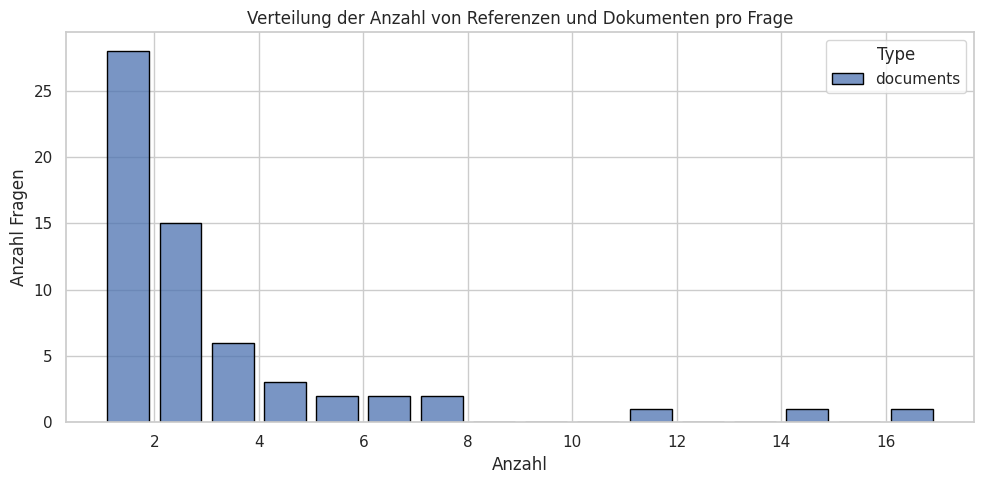

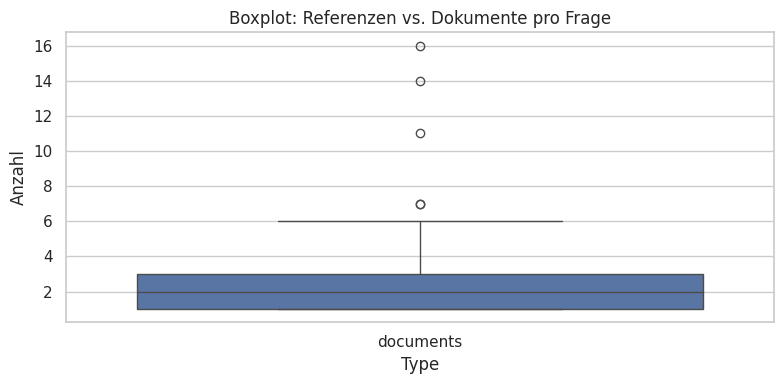

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

doc_counts = df["documents"].apply(len)

plot_df = (
    pd.DataFrame({
        "documents": doc_counts
    })
    .melt(var_name="Type", value_name="Count")
)

sns.set(style="whitegrid")

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=plot_df, x="Count", hue="Type", multiple="dodge", shrink=0.8, bins=range(1, max(plot_df["Count"]) + 2), edgecolor="black")
plt.title("Verteilung der Anzahl von Referenzen und Dokumenten pro Frage")
plt.xlabel("Anzahl")
plt.ylabel("Anzahl Fragen")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=plot_df, x="Type", y="Count")
plt.title("Boxplot: Referenzen vs. Dokumente pro Frage")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

### Check Reference to Document Mapping

Checks if the documents mapped to the question contain all the references from that question.

In [ ]:
from utils.string_utils import normalize
import pandas as pd

# Show all columns, rows, and avoid truncating column content
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

def find_missing_refs(references, documents):
    normalized_refs = [normalize(ref) for ref in references if isinstance(ref, str)]
    normalized_doc_texts = [normalize(doc.content) for doc in documents]
    full_text = " ".join(normalized_doc_texts)
    # Return only those references not found in the text
    missing_refs = [ref for ref in normalized_refs if ref not in full_text]
    return missing_refs

# Apply function to extract missing references
df["missing_refs"] = df.apply(
    lambda row: find_missing_refs(row["references"], row["documents"]), axis=1
)

# Only keep rows with missing references
failed_rows = df[df["missing_refs"].apply(len) > 0]

print(f"{len(failed_rows)} rows have missing reference matches.")
print(failed_rows[["question", "references", "missing_refs", "documents"]])

1 rows have missing reference matches.
                                                                                      question  \
43  Welche Risiken bestehen bei der Verwendung eines Beatmungstubus während einer Vollnarkose?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## Flatten Question Variations

In [5]:
df = pd.read_pickle("data/question_answers_with_documents.pkl")

In [16]:
import json
import pandas as pd
from tqdm import tqdm

new_rows = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Flattening Question Variations"):
    # 0) Include the original row itself
    orig = row.copy()
    orig["variant"]       = "default"
    orig["prev_messages"] = []
    new_rows.append(orig)

    # 1) Unpack each variation
    variations = json.loads(row["variations"])
    for variation_key, variation_val in variations.items():
        nr = row.copy()
        nr["variant"] = variation_key

        if variation_key == "contextual" and isinstance(variation_val, list):
            nr["question"]      = variation_val[-1]["message"]
            nr["prev_messages"] = [m["message"] for m in variation_val[:-1]]
        else:
            nr["question"]      = variation_val
            nr["prev_messages"] = []

        new_rows.append(nr)

# 2) Build your flattened DataFrame and drop 'variations'
flat_df = (
    pd.DataFrame(new_rows)
      .reset_index(drop=True)
      .drop(columns=["variations"])
)

Flattening Question Variations:   0%|          | 0/61 [00:00<?, ?it/s]

Flattening Question Variations: 100%|██████████| 61/61 [00:00<00:00, 231.07it/s]


In [17]:
flat_df

,question,references,groundTruth,source_file,documents,variant,prev_messages
0,Wie läuft eine äußere Wendung ab und was passi...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,default,[]
1,Und wie lange dauert dieser Eingriff normalerw...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,contextual,"[Wie läuft eine äußere Wendung ab?, Bei der äu..."
2,"Ey, wie machen die eigentlich so 'ne äußere We...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,slang,[]
3,How is an external version done and what happe...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,english,[]
4,"Können Sie mir erklären, wie eine äußere Wendu...",[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,[Document(id=ea0c518b7c51e474b09770e8db9709652...,german-variation-1,[]
...,...,...,...,...,...,...,...
605,"Was ist zu tun, wenn nach der Geburtseinleitun...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-2,[]
606,"Kann mir jemand sagen, was ich machen soll, we...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-3,[]
607,Ich hatte eine Geburtseinleitung – was mache i...,[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-4,[]
608,"Was empfehlen Sie, wenn nach der Einleitung de...",[Bei jeder medikamentösen oder mechanischen Me...,Sollten nach der Geburtseinleitung starke oder...,Einleitung der Geburt.md,[Document(id=8a64407f7a87fa95d3ce2f268e6b00c66...,german-variation-5,[]


In [18]:
flat_df.to_pickle("data/question_answers_with_documents_flat.pkl")